In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pystan
from dataclasses import dataclass
from typing import OrderedDict
import matplotlib.pyplot as plt

In [2]:
# Dummy data generation

In [3]:
@dataclass(frozen=True)
class SingleParameterModel:
    a: float
    b: float
    
    def __post_init__(self):
        assert 0 < self.a < 1
        assert 0 < self.b
        
    def __call__(self, x: float) -> float:
        return self.b * (x ** self.a) - x
    
    @staticmethod
    def of_vertex(x: float, y: float):
        a = x / (x + y)
        b = 1 / (a * ( x ** ( a - 1 )))
        return SingleParameterModel(a, b)
        
    @staticmethod
    def of_two_points(x_1: float, y_1: float, x_2: float, y_2: float):
        a = (np.log(x_2 + y_2) - np.log(x_1 + y_1)) / (np.log(x_2) - np.log(x_1))
        b = (y_1 + x_1) / (x_1**a)
        return SingleParameterModel(a, b)
        
    @staticmethod
    def of_stanfit(stanfit):
        extracted = stanfit.extract()
        assert "a" in extracted
        assert "b" in extracted
        a = np.median(extracted["a"])
        b = np.median(extracted["b"])
        return SingleParameterModel(a, b)
        

In [4]:
f = SingleParameterModel.of_vertex(2000, 500)
g = SingleParameterModel.of_two_points(10, f(10), 1000, f(1000))

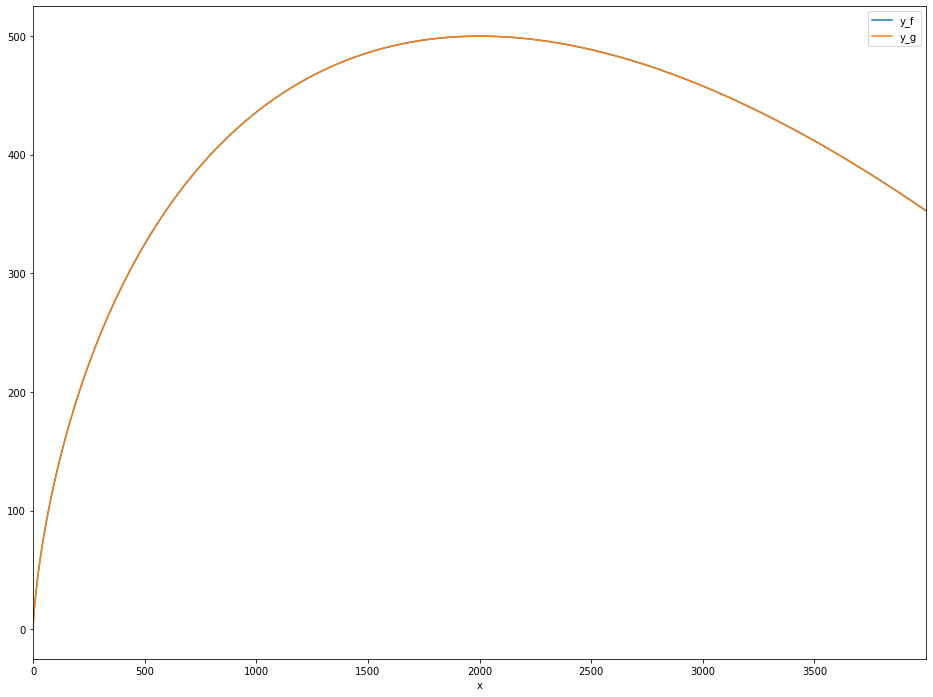

In [5]:
pd.DataFrame({"x": list(range(0, 4000, 1))}).assign(
    y_f=lambda df: df.x.map(f),
    y_g=lambda df: df.x.map(g)
).set_index("x").plot(figsize=(16, 12))

In [6]:
n_sample = 50
dummy_data = pd.DataFrame({}).assign(
    x=np.random.uniform(50, 350, n_sample)
).assign(
    x=lambda df: df.x.map(round).map(lambda x: x*10)
).assign(
    y=lambda df: df.x.map(f)
).assign(
    y_obs = lambda df: df.y + np.random.normal(0, 30, n_sample)
)

In [7]:
dummy_data

,x,y,y_obs
0,2370,493.615398,469.472261
1,1750,496.707066,472.677412
2,2860,468.195573,501.218119
3,1100,449.637653,423.678151
4,1320,472.978811,488.546257
5,1910,499.587524,532.552380
6,2040,499.920633,532.752882
7,3340,428.019881,454.713571
8,880,416.289938,404.677914
9,3270,434.709971,480.111283


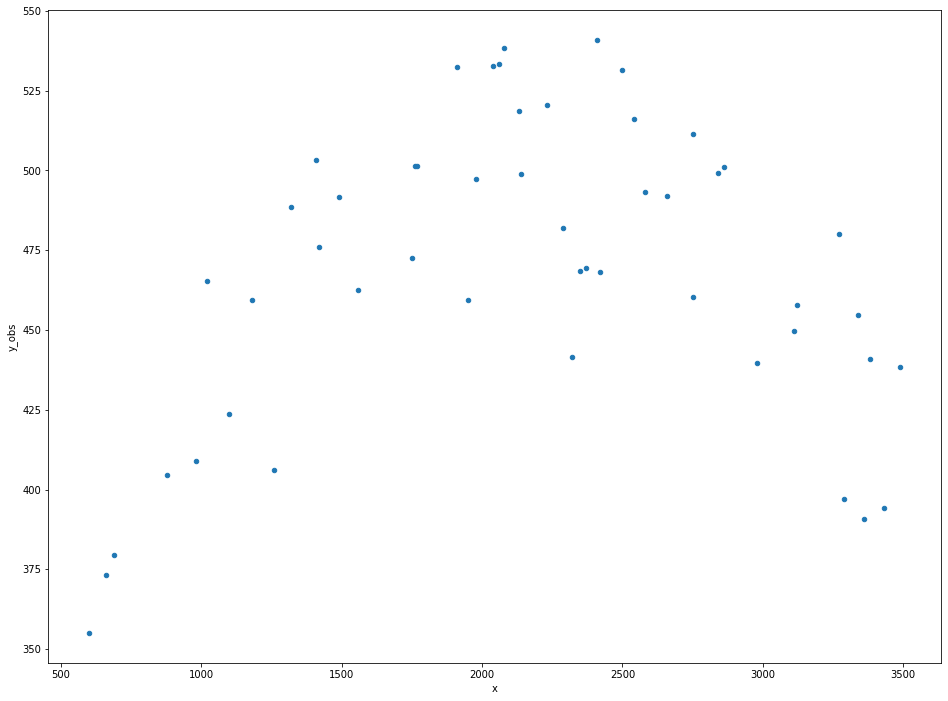

In [8]:
dummy_data.plot.scatter(x="x", y="y_obs", figsize=(16, 12))
plt.savefig('profit_scatter.png')

In [9]:
# modeling with generated data

In [10]:
data = {
    "x": dummy_data.x.to_list(),
    "y": dummy_data.y_obs.to_list(),
    "n": dummy_data.shape[0]
}

In [13]:
model_code = """
data {
    int n;
    vector[n] x;
    vector[n] y;
}
parameters {
    real<lower=0, upper=1> a;
    real<lower=0> b;
    real<lower=0> sigma;
}
transformed parameters {
    vector<lower=0>[n] y_p;
    for(i in 1:n)
        y_p[i] = b*(x[i]^a) - x[i]; 
}
model {
    a ~ uniform(0, 1);
    b ~ uniform(0, 100);
    sigma ~ normal(0, 100);
    y ~ normal(y_p, sigma);
}
"""

In [17]:
model = pystan.StanModel(model_code=model_code)
stanfit = model.sampling(data=data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_22a19322936018b8c8eaec3e5754494d NOW.


In [18]:
stanfit

Inference for Stan model: anon_model_22a19322936018b8c8eaec3e5754494d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a          0.8  1.3e-4 4.6e-3   0.79    0.8    0.8   0.81   0.81   1180   1.01
b         5.59  5.8e-3    0.2    5.2   5.46   5.59   5.72   5.98   1188   1.01
sigma    27.94    0.08   2.96   22.8  25.81  27.73  29.77  34.62   1517    1.0
y_p[1]   497.0    0.07   4.15 488.58 494.22 497.06 499.79 505.04   4029    1.0
y_p[2]  497.22    0.12   4.86 487.61 493.93 497.24 500.44 506.75   1747    1.0
y_p[3]   474.1     0.1   5.23 463.83 470.55 474.08 477.58 484.47   2862    1.0
y_p[4]  447.73    0.17   6.23 435.18 443.54 447.82 451.94 460.18   1308    1.0
y_p[5]   471.8    0.16   5.83 460.06 467.87  471.9 475.71 483.33   1384    1.0
y_p[6]   500.8     0.1   4.54 491.84 497.77 500.88  503.8 509.71   2057    1.0
y_p[7]  501.72    0.0

In [19]:
h = SingleParameterModel.of_stanfit(stanfit)

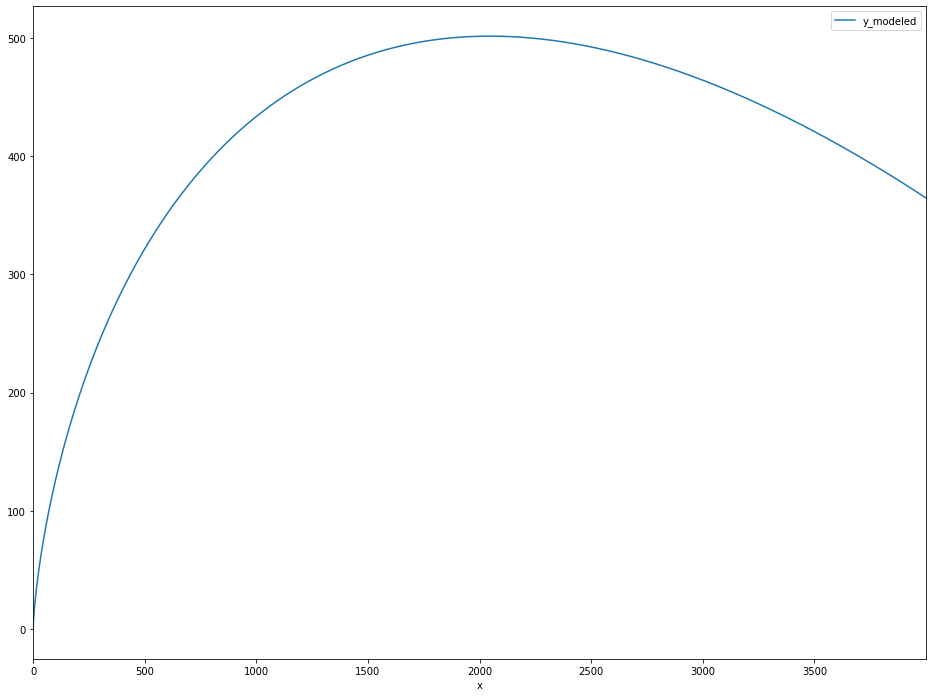

In [20]:
modeled_data= pd.DataFrame({"x": list(range(0, 4000, 1))}).assign(
    y_modeled=lambda df: df.x.map(h)
)
modeled_data.set_index("x").plot(figsize=(16, 12))
plt.savefig('profit_modeled.png')

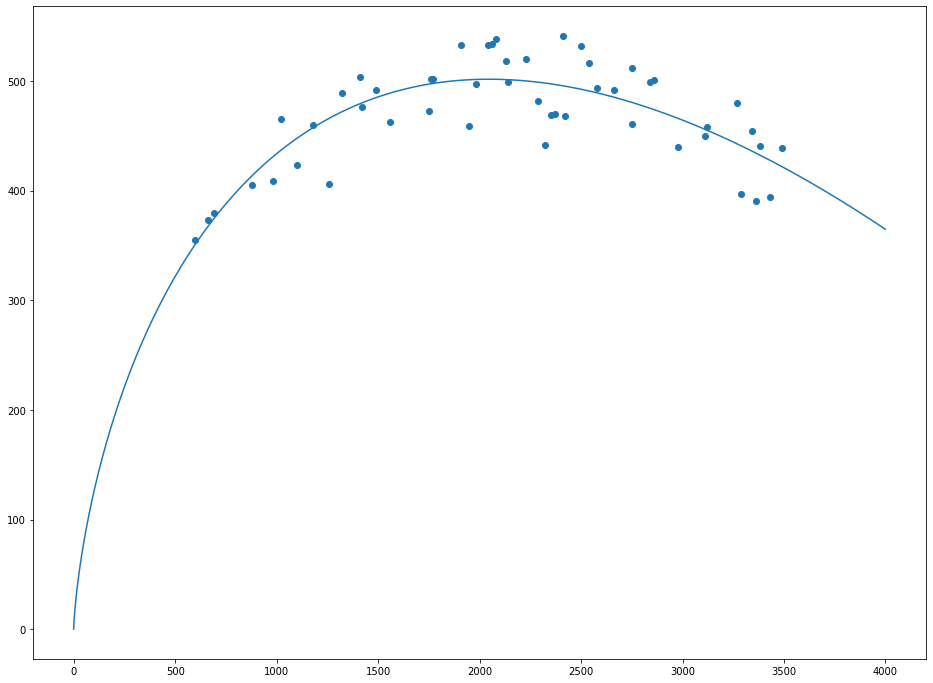

In [21]:
fig, ax = plt.subplots(figsize=(16,12))
ax.scatter(x=dummy_data["x"], y=dummy_data["y_obs"])
ax.plot(modeled_data["x"], modeled_data["y_modeled"])

In [22]:
fig.savefig('profit_modeled_observed.png')

In [23]:
# plot for articles

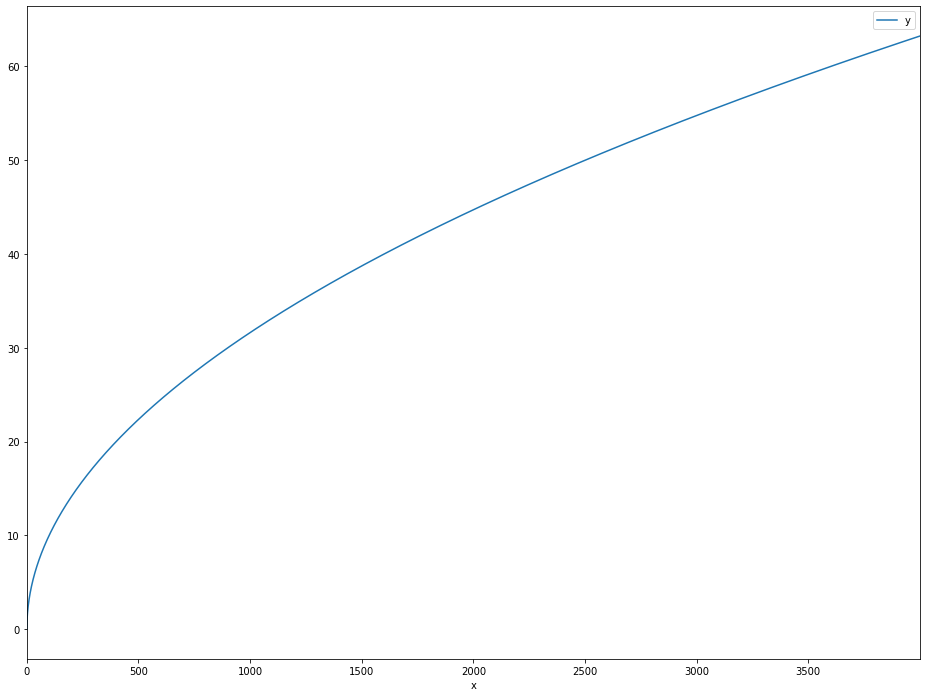

In [24]:
pd.DataFrame({"x": list(range(0, 4000, 1))}).assign(
    y=lambda df: df.x.map(lambda x: (x**0.5))
).set_index("x").plot(figsize=(16, 12))
plt.savefig('decay.png')

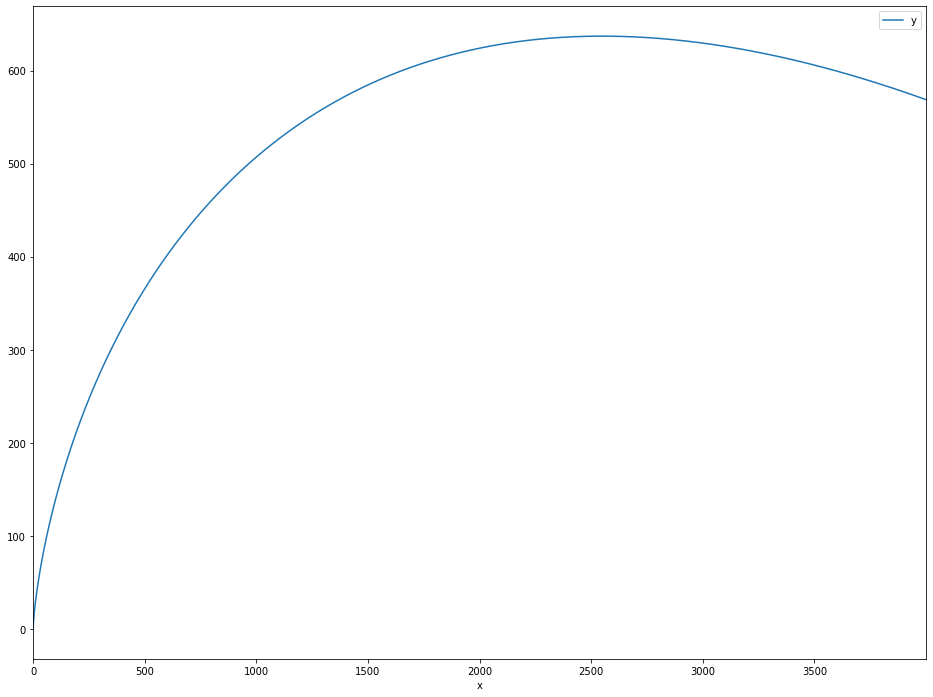

In [25]:
pd.DataFrame({"x": list(range(0, 4000, 1))}).assign(
    y=lambda df: df.x.map(SingleParameterModel(0.8, 6.0))
).set_index("x").plot(figsize=(16, 12))
plt.savefig('profit_example.png')

In [27]:
dummy_data.to_csv("dummy_data.csv")

In [30]:
dummy_data.assign(
    y=lambda df: df.y.map(round)
)[["x", "y"]]

,x,y
0,2370,494
1,1750,497
2,2860,468
3,1100,450
4,1320,473
5,1910,500
6,2040,500
7,3340,428
8,880,416
9,3270,435
